# Choosing MW like galaxies from SPARC dataset (already fitted with NFW profile in previous works)

## Selection criteria 
    1. M200 and Md,star of gal, within error, should be within the fiducial MW range.
    2. Rotation curve should match to each other based on the below mentioned criteria*.
    3. Morphology should be same. ( Need bulge, stellar disc scale length requirement, C200 criteria is relaxed, Rd,bul should be less than 2kpc, Rdgas should be extended and leaves a relatively large scale, ignored the 'hole' )

## *Rotation curve criteria
    Angular velocity $\omega = V(r)/r$ of the RC should match that of the MW's (compiled from PB's and Elier's works). The matching criteria is set as $\sqrt{\chi^2/d.o.f} < 60$, where \chi^2 is eq() in the paper and the degrees of freedom (d.o.f) is the total number of data points falling in the radial range 2-30 kpc (D) - 1. 

## Errors considered for mass model parameter
    - For DM halo parameters $\Delta M200, \Delta C200$ are obtained from MCMC chains.
    - The baryonic mass model parameters are assumed to have a +- 10 percent error.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import json,os,sys
import pickle

In [3]:
# Importing mass model data of SPARC RCs already fitted (with NFW DM density profile) in previous works.
sparcd = json.load(open('../../Accessory/sparc_dict.json','r'))
prior = 'lcdm_reg'
# Importing MW dict
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))

5.27 24.82


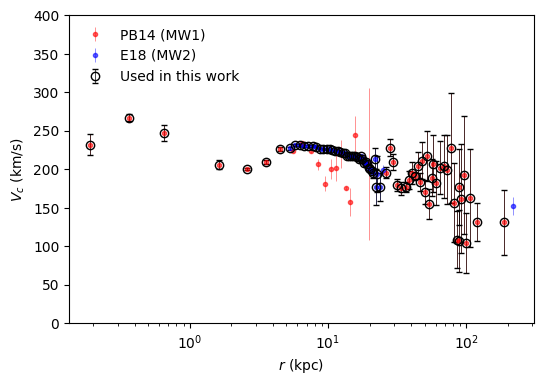

In [67]:
# Importing MW RC data (Eilers + PB, provided by Aakash (IMPRS))
# RC data of MW compiled from  PB 2014 (0 < r < 5 and 25 < r < 220 kpc) and Eilers 2018 (5 < r < 25 kpc)
#(../../Accessory/mw1.dat) and #Eilers(../../Accessory/mw2.dat).

mw1 = np.loadtxt('../../Accessory/mw1.dat')
mw2 = np.loadtxt('../../Accessory/mw2.dat')
indx = np.where(mw1[:,0] == 8.0) # Assuming Rsun = 8kpc and Vsun = 200 km/s for obtaining the data from PB 2014.

mw_r1 = mw1[:,2][indx]
mw_v1 = mw1[:,3][indx]
mw_e1 = mw1[:,4][indx]
mw_r2 = mw2[:,0]
mw_v2 = mw2[:,1]
mw_e2 = np.mean((mw2[:,2],mw2[:,3]),axis = 0)

r_start = mw_r2[0]
r_stop = mw_r2[-2]
print (r_start, r_stop)

mw_r = np.concatenate((mw_r1[mw_r1 < r_start],mw_r2[:-2],mw_r1[mw_r1 > r_stop]))
mw_v = np.concatenate((mw_v1[mw_r1 < r_start],mw_v2[:-2],mw_v1[mw_r1 > r_stop]))
mw_e = np.concatenate((mw_e1[mw_r1 < r_start],mw_e2[:-2],mw_e1[mw_r1 > r_stop]))

argsort = np.argsort(mw_r)
mw_r = mw_r[argsort]
mw_v = mw_v[argsort]
mw_e = mw_e[argsort]

mw_w = mw_v/mw_r
mw_we = mw_w*(mw_e/mw_v)

fig,ax = plt.subplots(figsize = (6,4))
ax.errorbar(mw_r1, mw_v1, mw_e1, c = 'r', elinewidth = 0.5, fmt = '.', label = 'PB14 (MW1)', alpha = 0.6)
ax.errorbar(mw_r2, mw_v2, mw_e2, c = 'b', elinewidth = 0.5, fmt = '.', label = 'E18 (MW2)', alpha = 0.6)
ax.errorbar(mw_r, mw_v, mw_e, c = 'None', ecolor = 'k', capsize = 2, elinewidth = 0.5, fmt = 'o', 
            label = 'Used in this work', alpha = 1,mec = 'k')
ax.set_xscale('log')
ax.set_ylim(0,400)
ax.legend(loc = 'upper left',framealpha = 0)
ax.set_xlabel('$r$ (kpc)')
ax.set_ylabel('$V_c$ (km/s)');

In [46]:
# To check if there is any overlap between the estimated (1sigma) range and the fiducial range.
overlap = lambda a, e_a, a_min, a_max: (np.around(a - e_a,1) <= a_max) and (np.around(a + e_a,1) >= a_min)

def RC_criteria(r, vc, ve, r_min = 3.0, r_max = 30.0):
    """
    This is to check if the RC of the gal is a match to MW's. 
    Note that sparc_dict.json and MW RC data are assumed to be
    loaded and are defined as sparcd and mwd.
    -----------
    gal: (string) name of the galaxy
    """
    vc_fn = sp.interpolate.interp1d(r,vc,
                                    kind = 'cubic',
                                    bounds_error = False,
                                    fill_value = 'extrapolate')
    ve_fn = sp.interpolate.interp1d(r,ve,
                                    kind = 'cubic',
                                    bounds_error = False,
                                    fill_value = 'extrapolate')
    chisq, cnt = 0, 0
    for i in range(len(mw_r)):
        r = mw_r[i]
        if (r < r_min) or (r > r_max):
            continue
        chisq += (mw_w[i] - vc_fn(r)/r)**2/(mw_we[i]**2 + (ve_fn(r)/r)**2)
        cnt += 1
    return chisq/float(cnt - 1)

def morph_criteria(gal):
    gdict = sparcd[prior][gal]
    gald = gdict['cusp_fit']
    bulge = gdict['bulge']
    if not bulge:
        return False

    mdbul_min, mdbul_max = MW_dict['fiducial_range']['mdbul']
    mdbul_mean = 0.5*(mdbul_min + mdbul_max)
    mdbul_widt = 0.5*(mdbul_max - mdbul_min)
    mdbul_fid = [mdbul_mean - 2.2*mdbul_widt, 
                 mdbul_mean + 2.2*mdbul_widt] # it is 2.2 only
                # for UGC05253, for all other MW-like galaxies,
                # using 2 is sufficient.
    mdbul = 10**(gald['lmbul'][0]-9)
    emdbul = 0.1*mdbul
    if not overlap(mdbul, emdbul, *mdbul_fid):
        return False

    if not (gald['rdbul'][0] - gald['rdbul'][1] < 2.0):
        return False

    mdgas_min, mdgas_max = MW_dict['fiducial_range']['mdgas']
    mdgas_mean = 0.5*(mdgas_min + mdgas_max)
    mdgas_widt = 0.5*(mdgas_max - mdgas_min)
    mdgas_fid = [mdgas_mean - mdgas_widt, 
                 mdgas_mean + mdgas_widt]
    mdgas = 10**(gald['lmgas'][0]-9)
    emdgas = 0.1*mdgas
    if not overlap(mdgas, emdgas, *mdgas_fid):
        return False

    rdgas_min, rdgas_max = MW_dict['fiducial_range']['rdgas']
    rdgas_mean = 0.5*(rdgas_min + rdgas_max)
    rdgas_widt = 0.5*(rdgas_max - rdgas_min)
    rdgas_fid = [rdgas_mean - 2*rdgas_widt,
                 rdgas_mean + 2*rdgas_widt]
    rdgas = gald['rdgas'][0]
    erdgas = 0.1*rdgas
    if not overlap(rdgas, erdgas, *rdgas_fid):
        return False
    else:
        return True

In [47]:
# Selection of MW-like galaxies using criteria 1, 2 and 3
selection = {f'criteria-{i}':[] for i in range(1,4)}
selection['criteria-12'] = []
selection['criteria-123'] = []

for gal in sparcd[prior].keys():
    gdict = sparcd[prior][gal]
    gald = gdict['cusp_fit']
    
    m200, em200 = np.array(gald['m200'])*1e-12
    mdstar = 10**(gald['lmdisk'][0]-9)
    emdstar = 0.1*mdstar
    m200_fid = MW_dict['fiducial_range']['m200']
    mdstar_fid = MW_dict['fiducial_range']['mdstar']
    
    # Selection criteria - 1
    if overlap(m200, em200, *m200_fid) and overlap(mdstar, emdstar, *mdstar_fid):
        selection['criteria-1'].append(gal)
        
        # print(f'M200:, ({m200-em200:.1f}, {m200+em200:.1f}), ({m200_fid[0]:.1f}, {m200_fid[1]:.1f})')
        # print(f'Mdstar:, ({mdstar-emdstar:.1f}, {mdstar+emdstar:.1f}), ({mdstar_fid[0]:.1f}, {mdstar_fid[1]:.1f})')
    
    # Selection criteria - 2
    rc_criteria = RC_criteria(gdict['r'],gdict['vc'],gdict['ve'])
    if rc_criteria < 150.0:
        selection['criteria-2'].append(gal)

    # Selection criteria - 3
    if morph_criteria(gal):
        selection['criteria-3'].append(gal)

    if (gal in selection['criteria-1']) and (gal in selection['criteria-2']):
        selection['criteria-12'].append(gal)
        if (gal in selection['criteria-3']):
            selection['criteria-123'].append(gal)

print ('MW-like galaxies satisfying criteria 1, 2 and 3:')
for i,gal in enumerate(selection['criteria-123']):
    print (f'  {i+1}. {gal}')

mwgals = selection['criteria-123']

MW-like galaxies satisfying criteria 1, 2 and 3:
  1. NGC4013
  2. NGC4157
  3. NGC4217
  4. NGC5985
  5. NGC7814
  6. UGC03546
  7. UGC05253


In [48]:
# To find MW-like RC criteria band

def get_MWband():
    indx = np.where((mw_r > 3) & (mw_r < 30))[0]
    logr = np.log10(mw_r[indx])
    logw = np.log10(mw_w[indx])
    loge = np.log10(mw_we[indx])
    
    line_logw = lambda logr, m, c: m*logr + c
    mw_line,_ = sp.optimize.curve_fit(line_logw, logr, logw, sigma = loge, p0 = [-1, 1])
    r_gal = np.logspace(np.log10(3), np.log10(30), 10)
    vc_gal = lambda logr, c: 10**(mw_line[0]*logr + (mw_line[1]+c))*10**logr
    ve_gal = lambda logr, c: 0.05*vc_gal(logr, c)
    fit_fn = lambda c: RC_criteria(r_gal, vc_gal(np.log10(r_gal), c), ve_gal(np.log10(r_gal), c)) - 150.0
    Δc = sp.optimize.fsolve(fit_fn, x0 = [0])
    return [logr, logw, loge, mw_line, Δc]

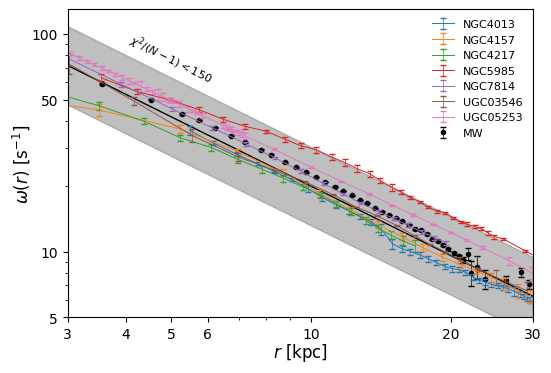

In [49]:
#Plotting angular velocity curves of MW and MW-like galaxies
fig,ax = plt.subplots(figsize = (6,4))

res = get_MWband()
logr, logw, loge, mw_line, Δc = res
logr = np.linspace(np.log10(3),np.log10(30),10)
mw_logw = mw_line[0]*logr + mw_line[1]

# MW-like galaxies
for gal in mwgals:
    gdict = sparcd[prior][gal]
    r = np.array(gdict['r'])
    vc = np.array(gdict['vc'])
    ve = np.array(gdict['ve'])
    sc_mwlike = ax.errorbar(r, vc/r, ve/r, capsize = 2, fmt = '-',
                     elinewidth = 0.5,zorder = 2,
                     linewidth = 0.7,label = gal)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(3,30)
ax.set_ylim(5,130)

# MW
sc_mw = ax.errorbar(mw_r, mw_w, mw_we, c = 'k', fmt = '.', zorder = 1,
            alpha = 1, mec = 'k', capsize = 2,
            elinewidth = 0.5, label = 'MW')
fb_mw = ax.fill_between(10**logr, 10**(mw_logw + Δc), 10**(mw_logw - Δc),
                        color = 'grey',alpha = 0.5,zorder = 0)
pl_mw = ax.plot(10**logr, 10**mw_logw, c = 'k',linewidth = 1, zorder = 1)


ax.set_xticks([3,4,5,6,10,20,30],minor = [])
ax.set_xticklabels([3,4,5,6,10,20,30],minor = [])
yticks = [5,10,50,100]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.legend(framealpha = 0,prop = {'size': 8})

ax.set_xlabel('$r$ [kpc]',size = 12,labelpad = 0)
ax.set_ylabel('$\omega(r) \,\, \mathrm{[s^{-1}]}$',size = 12, labelpad = 0)

ax.text(4, 60, '$\chi^2/(N-1) < 150$',size = 8, rotation = -26.5);

plt.savefig('../Output/figures/MW_like_RC.pdf',bbox_inches = 'tight',dpi = 300)

In [50]:
"""Too create a table of the form:
    --------------------------------------
    Galaxy      param1    param2    param3
    --------  --------  --------  --------
    MW               1         2         3
    gal1             1         2         3
    gal2             1         2         3
    --------------------------------------"""

params = ['$M_{200}$','$c_{200}$','$M_\mathrm{d,star}$',
          'R_\mathrm{d,star}','$M_\mathrm{d,gas}$',
          '$R_\mathrm{d,gas}$', '$M_\mathrm{d,bul}$'] 

gdict = lambda gal,key: np.array(sparcd[prior][gal][key])
gald = lambda gal,key: np.array(sparcd[prior][gal]['cusp_fit'][key])
witherr = lambda p: r'%.1f $\pm$ %.1f'%(p[0],p[1])
noerr = lambda p: f'${p:.1f}$'

m200_row = [witherr(1e-12*gald(gal, 'm200')) for gal in mwgals]
c200_row = [witherr(gald(gal, 'c200')) for gal in mwgals]
mdstar_row = [noerr(10**(gald(gal, 'lmdisk')[0] - 9)) for gal in mwgals]
rdstar_row = [witherr(gald(gal, 'rdstar')) for gal in mwgals]
mdgas_row = [noerr(10**(gald(gal, 'lmgas')[0] - 9)) for gal in mwgals]
rdgas_row = [witherr(gald(gal, 'rdgas')) for gal in mwgals]
mdbul_row = [noerr(10**(gald(gal, 'lmbul')[0] - 9)) for gal in mwgals]

table = np.array([m200_row, c200_row, mdstar_row, 
                  rdstar_row, mdgas_row, rdgas_row, 
                  mdbul_row]).T

mw_fid = MW_dict['fiducial_range']
keys = ['m200', 'c200', 'mdstar', 'rdstar', 'mdgas', 'rdgas', 'mdbul']
mw_params = [f'({mw_fid[key][0]:.1f}, {mw_fid[key][1]:.1f})' for key in keys]
table = np.vstack((mw_params, table))

In [51]:
from tabulate import tabulate
print (tabulate(table, headers = ['Galaxy'] + keys, tablefmt = 'simple',
                showindex = ['MW'] + mwgals))

Galaxy    m200           c200            mdstar        rdstar         mdgas        rdgas           mdbul
--------  -------------  --------------  ------------  -------------  -----------  --------------  -----------
MW        (0.9, 1.6)     (9.0, 17.0)     (42.0, 63.0)  (2.0, 4.0)     (1.0, 20.0)  (5.0, 20.0)     (8.0, 20.0)
NGC4013   1.6 $\pm$ 0.4  4.7 $\pm$ 0.7   $38.7$        3.5 $\pm$ 0.4  $3.9$        8.0 $\pm$ 0.1   $12.2$
NGC4157   1.2 $\pm$ 0.5  6.5 $\pm$ 1.5   $43.7$        2.3 $\pm$ 0.2  $10.9$       8.8 $\pm$ 0.1   $1.2$
NGC4217   1.8 $\pm$ 0.8  7.6 $\pm$ 1.4   $68.2$        2.9 $\pm$ 0.3  $3.4$        6.5 $\pm$ 0.1   $12.6$
NGC5985   1.5 $\pm$ 0.1  27.0 $\pm$ 1.1  $62.2$        7.0 $\pm$ 0.7  $15.4$       26.6 $\pm$ 0.2  $7.2$
NGC7814   1.1 $\pm$ 0.3  13.2 $\pm$ 2.3  $48.7$        2.5 $\pm$ 0.3  $1.4$        10.7 $\pm$ 0.2  $24.5$
UGC03546  0.9 $\pm$ 0.1  9.1 $\pm$ 1.0   $59.9$        3.8 $\pm$ 0.4  $3.6$        12.7 $\pm$ 0.2  $10.2$
UGC05253  1.2 $\pm$ 0.0  15.5 $\pm$ 0.7

In [53]:
# Storing data in MWlike (dict)
MWlike = {'gals':['MW']+mwgals,
          'mwgals':mwgals,
          'table':table,
          'params':params,
          'param_keys':keys,}

pm_10 = lambda x: np.array([x, 0.1*x])
MWlike['massmodels'] = {'m200': [1e-12*np.array(gald(gal, 'm200')) for gal in mwgals],
                        'c200': [np.array(gald(gal, 'c200')) for gal in mwgals],
                        'mdstar': [pm_10( 10**(gald(gal, 'lmdisk')[0] - 9) ) for gal in mwgals],
                        'rdstar': [np.array(gald(gal, 'rdstar')) for gal in mwgals],
                        'mdgas': [pm_10( 10**(gald(gal, 'lmgas')[0] - 9 ) ) for gal in mwgals],
                        'rdgas': [np.array(gald(gal, 'rdgas')) for gal in mwgals],
                        'mdbul': [pm_10( 10**(gald(gal, 'lmbul')[0] - 9 ) ) for gal in mwgals],
                        'rdbul': [np.array(gald(gal, 'rdbul')) for gal in mwgals],
                        'rs': [np.array(gald(gal, 'rs')) for gal in mwgals]}

# pickle.dump(MWlike, open('../Output/MWlike_dict.pkl','wb'))

# MW_dict['RC'] = np.array([mw_r, mw_v, mw_e]).T
# pickle.dump(MW_dict, open('../Output/MW_dict.pkl','wb'))

# Including the VDF information of MWlike galaxies from previous studies at R = 8 kpc. 

In [ ]:
chaind = pickle.load(open('../../Accessory/chains_lcdm_reg_DDGB_8kpc.pkl','rb'))

In [ ]:
chains = chaind[gal]['nfw']['chain']

In [ ]:
for i, vdf in enumerate(chains):
    print (i, vdf.shape)

In [ ]:
v = np.linspace(0, 800, 250) # We set an uppper limit on Vesc = 800 km/s here
def get_vdf(gal, v = v):
    chains = chaind[gal]['nfw']['chain'] # chains[chain_no,
                                          # v, vdf]
    vdffn = lambda v_, vdf, v=v: sp.interpolate.interp1d(v_, vdf, kind = 'cubic', bounds_error = False, fill_value = 0, assume_sorted = True)(v)
    filternan = lambda vdfs: vdfs[~np.any(np.isnan(vdfs), axis = 1)]
    vdfs_ = np.array([vdffn(vdf[:,0], vdf[:,1]) for vdf in chains])
    vdfs = filternan(vdfs_)

    vdf_m = np.array([np.percentile(vdfs[:,i], 50) for i in range(len(v))])
    vdf_16_84 = np.array([np.percentile(vdfs[:,i], (16,84)) for i in range(len(v))])
    vdf_05_95 = np.array([np.percentile(vdfs[:,i], (5,9)) for i in range(len(v))])

    return (v, vdf_m, vdf_16_84, vdf_05_95)

In [ ]:
# VDF of MWlike galaxies
# Note we have set a limit on the value of Vesc at 800 km/s here
v = np.linspace(0, 800, 250)
VDFs_m = []
VDFs_16_84 = []
for gal in mwgals:
    print (gal)
    chains = chaind[gal]['nfw']
    v_,vdf_m_ = chains['v'],chains['vdf_m']
    
    # vdf_16_, vdf_4_ = chains['vdf_18_84']

    vdf_fn = lambda v_, vdf, v = v: sp.interpolate.interp1d(v_,vdf, kind = 'cubic',
                        bounds_error = False, 
                        fill_value = 0,
                        Assume_sorted = True)(v)

    if np.any(np.isnan(vdf_m_)):
        print (gal)

In [ ]:
chaind['NGC4013']['nfw']['chain'].shape

In [ ]:
chaind['NGC4157']['nfw']['chain']